In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [25]:
import os
import re
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from termcolor import colored

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from tensorflow.keras.applications.vgg19 import preprocess_input


print(colored('All libraries imported succesfully', 'green', attrs=["bold"]))

All libraries imported succesfully


In [3]:
warnings.filterwarnings('ignore')

print(colored('All libraries configed succesfully', 'green', attrs=['bold']))

All libraries configed succesfully


In [4]:
base_directory = '/home/nima/dataset-dw/dogs-vs-cats/'
train_folder = '/home/nima/dataset-dw/dogs-vs-cats/train/'
test_folder = '/home/nima/dataset-dw/dogs-vs-cats/test1/'

In [5]:
total_count = len(os.listdir(train_folder))
print(colored(f'Number of samples in train folder : {total_count}', 'blue', attrs=['bold']))

Number of samples in train folder : 25000


In [6]:
cat_count, dog_count = 0, 0
for file_name in os.listdir(train_folder) :
    cat = re.findall("\Acat", file_name)
    dog = re.findall("\Adog", file_name)
    if cat :
        cat_count+=1
    if dog :
        dog_count+=1
print(colored(f'Number of cats : {cat_count}', 'blue', attrs=['bold']))
print(colored(f'Number of dogs : {dog_count}', 'blue', attrs=['bold']))
total_count = [cat_count, dog_count]

Number of cats : 12500
Number of dogs : 12500


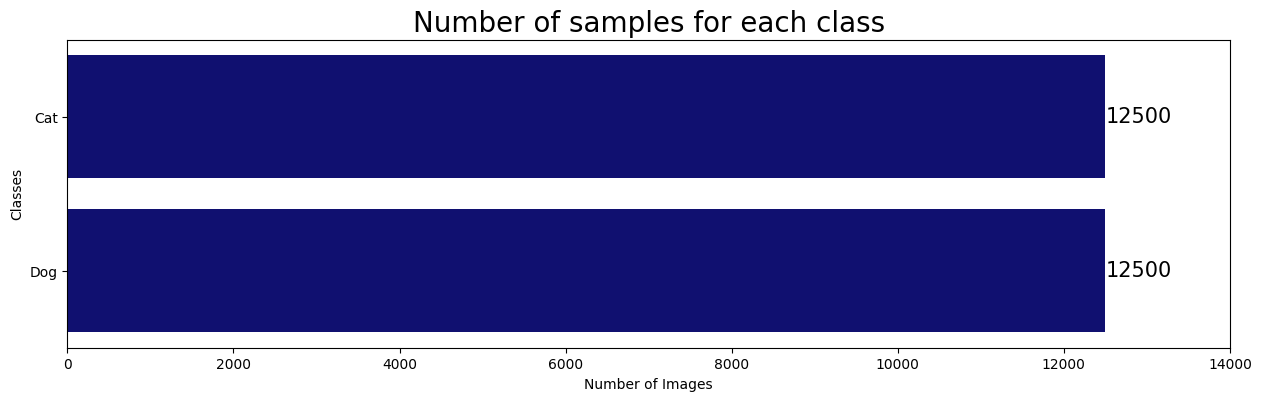

In [7]:
plt.figure(figsize=(15, 4))
ax = sns.barplot(x=total_count, y=['Cat', 'Dog'], orient='h', color='navy')
ax.set_xticks(np.arange(0, 14500, 2000))
ax.set_xlabel('Number of Images')
ax.set_ylabel('Classes')
ax.set_title('Number of samples for each class', fontsize=20)
for i, p in enumerate(ax.patches) :
    ax.text(p.get_width(), p.get_y() + p.get_height() / 2.,
            '{}'.format(total_count[i]), 
             va="center", fontsize=15)

In [8]:
temp_df = []
for file_name in os.listdir(train_folder) :
    if re.findall("\Acat", file_name) :
        class_name = 'cat'
    else :
        class_name = 'dog'
    temp_df.append((os.path.join(train_folder, file_name), class_name))
df = pd.DataFrame(temp_df, columns=['file_path', 'label'])
df

,file_path,label
0,/home/nima/dataset-dw/dogs-vs-cats/train/dog.7...,dog
1,/home/nima/dataset-dw/dogs-vs-cats/train/dog.1...,dog
2,/home/nima/dataset-dw/dogs-vs-cats/train/dog.2...,dog
3,/home/nima/dataset-dw/dogs-vs-cats/train/dog.6...,dog
4,/home/nima/dataset-dw/dogs-vs-cats/train/dog.3...,dog
...,...,...
24995,/home/nima/dataset-dw/dogs-vs-cats/train/dog.1...,dog
24996,/home/nima/dataset-dw/dogs-vs-cats/train/cat.8...,cat
24997,/home/nima/dataset-dw/dogs-vs-cats/train/dog.8...,dog
24998,/home/nima/dataset-dw/dogs-vs-cats/train/dog.5...,dog


In [9]:
# Plot 6 image for each class

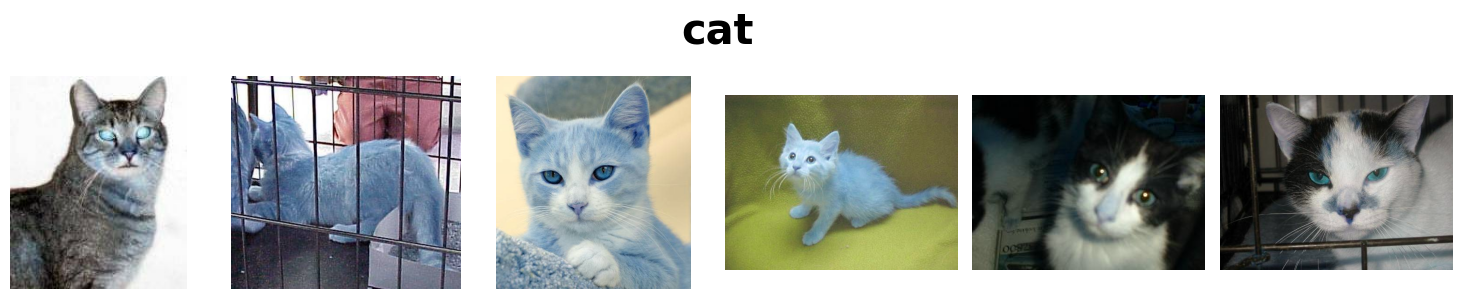

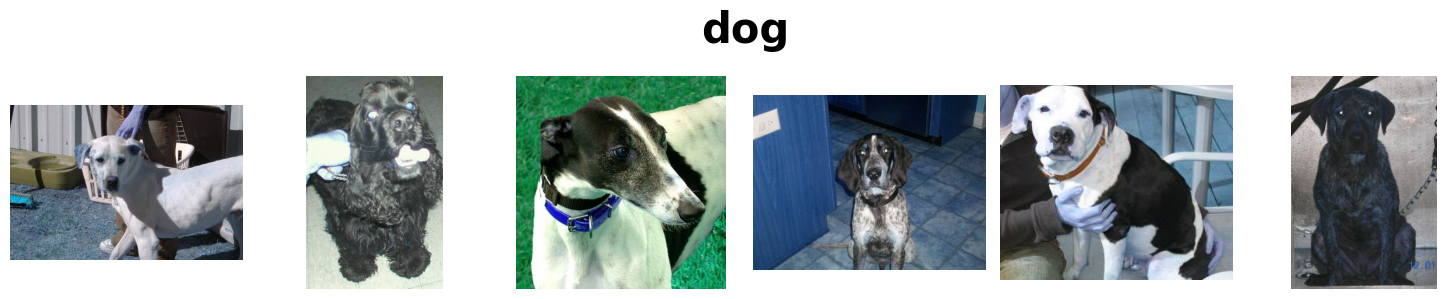

In [10]:
def plot_6_image(images, title) :
    plt.figure(figsize=(15, 3))
    for i, path in enumerate(images) :
        plt.subplot(1, 6, i+1)
        img = cv2.imread(path)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=30, fontweight='bold')
    plt.tight_layout()
    plt.show()
        
# Setting the random seed for reproducibility
np.random.seed(42)

for classes in ['cat', 'dog'] :
    temp_df = df.file_path[df.label==classes]
    random_image = np.random.choice(temp_df, 6)
    plot_6_image(random_image, classes)

In [11]:
def image_size(train_folder) :
    height = []
    width = []
    
    unique_dims = set()
    
    for file_name in os.listdir(train_folder) :
        img_path = os.path.join(train_folder, file_name)
        img = cv2.imread(img_path)
        if img is not None :
            unique_dims.add((img.shape[0], img.shape[1]))
            #
            width.append(img.shape[0])
            height.append(img.shape[1])

    if len(unique_dims)==1 :
        print(colored(f'All images have a unique shape of {list(unique_dims)[0]}', 'green', attrs=['bold']))
    else :
        print(colored(f'There are {len(unique_dims)} different image dimensions', 'red', attrs=['bold']))
        print(colored(f'Min height is {min(height)}, Min width is {min(width)}', 'red'))
        print(colored(f'Max height is {max(height)}, Max width is {max(width)}', 'red'))

In [12]:
image_size(train_folder)

There are 8513 different image dimensions
Min height is 42, Min width is 32
Max height is 1050, Max width is 768


In [13]:
train_df, val_df = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=42)


print(colored(f'Training shape : {train_df.shape}', 'green', attrs=['bold']))
print(colored(f'Validation shape : {val_df.shape}', 'green', attrs=['bold']))

Training shape : (20000, 2)
Validation shape : (5000, 2)


# Add noises

In [14]:
def add_gausian_noises(image, mean=0, std=0.05) :
    ''' Add Gausian noise to an image '''
    gaussian = np.random.normal(mean, std, image.shape)
    noisy_image = image + gaussian
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

In [15]:
def apply_blur (image, kernel_size=5) :
    ''' Apply gaussian blur to an image '''
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

In [16]:
def downsample_upsample(image, scale_percent=50) :
    ''' Downsample and upsample an image '''
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return cv2.resize(resized, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)

In [17]:
def augment_images(dataframe, base_dir):
    modified_data = []
    
    for _, row in dataframe.iterrows():
        img_path = row['file_path']
        label = row['label']
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Randomly apply one or more degradation methods
        choices = ['noise', 'blur', 'downsample']
        chosen_methods = random.sample(choices, k=random.randint(1, len(choices)))

        if 'noise' in chosen_methods:
            directory, filename = os.path.split(img_path)
            new_img_path = os.path.join(directory, f"noisy_{filename}")
            cv2.imwrite(new_img_path, img)
            img = add_gausian_noises(img)
            modified_data.append((new_img_path, label))
        if 'blur' in chosen_methods:
            directory, filename = os.path.split(img_path)
            new_img_path = os.path.join(directory, f"blur_{filename}")
            cv2.imwrite(new_img_path, img)
            img = apply_blur(img)
            modified_data.append((new_img_path, label))
        if 'downsample' in chosen_methods:
            directory, filename = os.path.split(img_path)
            new_img_path = os.path.join(directory, f"downup_{filename}")
            cv2.imwrite(new_img_path, img)
            img = downsample_upsample(img)
            modified_data.append((new_img_path, label))

        # # Save the new image with a modified name
        # directory, filename = os.path.split(img_path)
        # new_img_path = os.path.join(directory, f"modified_{filename}")
        # cv2.imwrite(new_img_path, img)

        # # Append the new image path and its label to the list
        # modified_data.append((new_img_path, label))

    # Create a DataFrame with the modified images and their respective labels
    modified_images_df = pd.DataFrame(modified_data, columns=['file_path', 'label'])

    # Return the updated DataFrame with both original and modified images
    return pd.concat([dataframe, modified_images_df], ignore_index=True)

In [18]:
train_df = augment_images(train_df, train_folder)
# val_df = augment_images(train_df, train_folder)

In [19]:
print(colored(f'Training shape : {train_df.shape}', 'green', attrs=['bold']))
print(colored(f'Validation shape : {val_df.shape}', 'green', attrs=['bold']))

Training shape : (60138, 2)
Validation shape : (5000, 2)


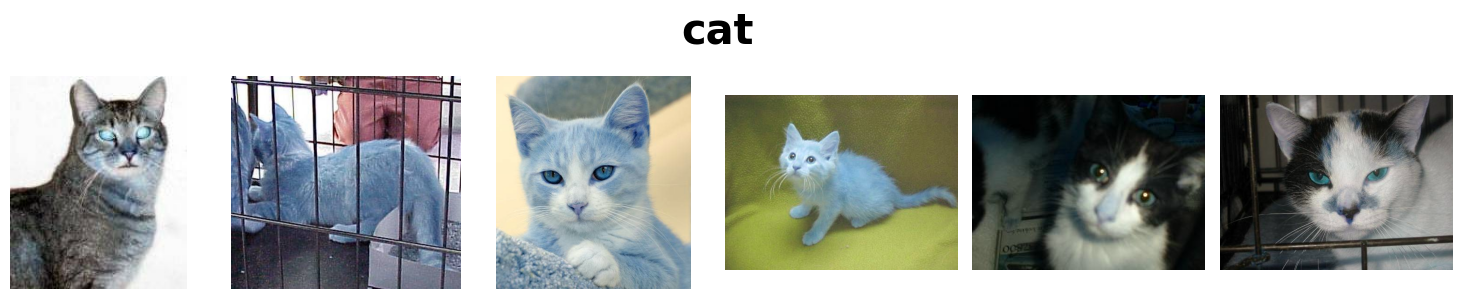

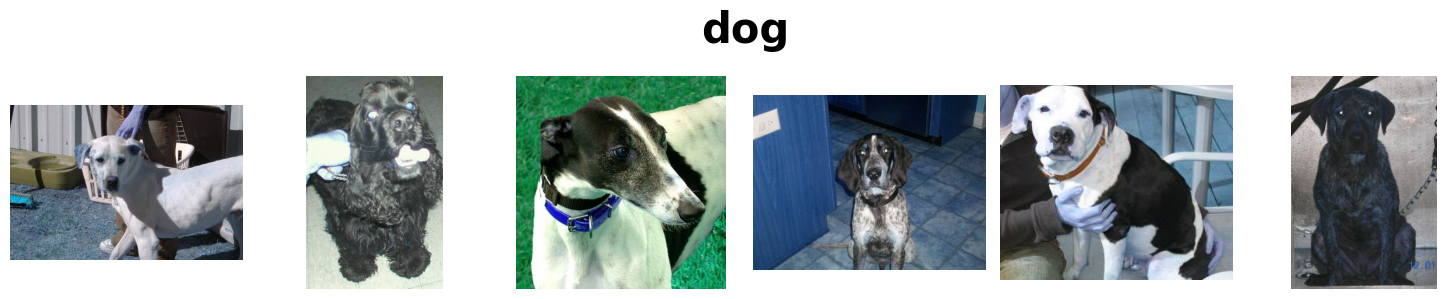

In [20]:
# Setting the random seed for reproducibility
np.random.seed(42)

for classes in ['cat', 'dog'] :
    temp_df = df.file_path[df.label==classes]
    random_image = np.random.choice(temp_df, 6)
    plot_6_image(random_image, classes)

In [23]:
def create_data_generator(train_df, val_df, preprocessing_function=None, batch_size=32, image_dimentions=(150, 150)) :
    train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=preprocessing_function
    )
    
    validation_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='file_path',
        y_col='label',
        target_size=image_dimentions,
        class_mode='categorical',
        batch_size=batch_size,
        seed=42,
        shuffle=True
    )
    
    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='file_path',
        y_col='label',
        target_size=image_dimentions,
        class_mode='categorical',
        batch_size=batch_size,
        seed=42,
        shuffle=False    
    )
    
    return train_generator, validation_generator

In [27]:
train_generator, val_generator = create_data_generator(train_df, val_df, preprocessing_function=preprocess_input)

# Fetch a batch of images and labels
batch_images, batch_labels = next(train_generator)

# Check the shape of the first image in the batch
print("Shape of the first image in the batch:", batch_images[0].shape)

Found 60138 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Shape of the first image in the batch: (150, 150, 3)
